In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np

In [2]:
df_test = pd.read_parquet('AQI_Historical_Dec_2022.parquet')
df_train = pd.read_parquet('AQI_Historical_New')

In [3]:
df_test = df_test[df_test['TRT_ID'] == 20]
df_train = df_train[df_train['TRT_ID'] == 20]
df=df_train

In [4]:
df_train['lat,lon,trt'] = 'Lat:' + df_train['coord.lat'].astype(str) + ', Lon:'+ df_train['coord.lon'].astype(str) + ', TRT_ID:' + df_train['TRT_ID'].astype(str)

In [5]:
df_train["dt"] = pd.to_datetime(df_train["dt"])
df_train = df_train.rename(columns={'dt':'ds','components.pm2_5':'y'})
df_train = df_train.drop('coord.lon', axis=1)
df_train = df_train.drop('coord.lat', axis=1)
df_train = df_train.drop('TRT_ID', axis=1)

In [6]:
df_train['y_orig'] = df_train['y']
df_train['y'] = np.log(df_train['y'])

In [7]:
df_train.head()

,ds,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,y,components.pm10,components.nh3,"lat,lon,trt",y_orig
0,2021-03-31 23:00:00,3,200.27,0.30,1.99,134.47,0.94,1.545433,10.93,1.50,"Lat:33.5032, Lon:-111.9297, TRT_ID:20",4.69
1,2021-04-01 00:00:00,3,201.94,0.28,2.61,134.47,1.04,1.591274,11.22,1.57,"Lat:33.5032, Lon:-111.9297, TRT_ID:20",4.91
2,2021-04-01 01:00:00,2,253.68,0.70,13.02,115.87,1.33,1.740466,12.62,2.28,"Lat:33.5032, Lon:-111.9297, TRT_ID:20",5.70
3,2021-04-01 02:00:00,2,327.11,0.16,26.73,87.98,1.59,1.902108,14.31,3.26,"Lat:33.5032, Lon:-111.9297, TRT_ID:20",6.70
4,2021-04-01 03:00:00,1,373.84,0.00,31.19,67.95,1.68,1.994700,15.67,3.93,"Lat:33.5032, Lon:-111.9297, TRT_ID:20",7.35


In [8]:
model_new = Prophet()
model_new.add_regressor('components.co')
model_new.add_regressor('components.no')
model_new.add_regressor('components.no2')
model_new.add_regressor('components.o3')
model_new.add_regressor('components.so2')
model_new.add_regressor('components.pm10')
model_new.add_regressor('components.nh3')

In [9]:
model_new.fit(df_train)

12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future_data = model_new.make_future_dataframe(periods=672, freq='H')

In [11]:
future_data.head()

,ds
0,2021-01-01 00:00:00
1,2021-01-01 01:00:00
2,2021-01-01 02:00:00
3,2021-01-01 03:00:00
4,2021-01-01 04:00:00


In [12]:
df = df.append(df_test)
df = df.rename(columns={'dt':'ds','components.pm2_5':'y'})
df = df.drop('coord.lon', axis=1)
df = df.drop('coord.lat', axis=1)


C:\Users\fashaikh\AppData\Local\Temp\ipykernel_21176\3139052309.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_test)


In [13]:
future_data = df[['ds','components.co', 'components.no', 'components.no2', 'components.o3', 'components.so2', 'components.pm10', 'components.nh3']]

In [14]:
future_data.head()

,ds,components.co,components.no,components.no2,components.o3,components.so2,components.pm10,components.nh3
0,2021-03-31 23:00:00,200.27,0.30,1.99,134.47,0.94,10.93,1.50
1,2021-04-01 00:00:00,201.94,0.28,2.61,134.47,1.04,11.22,1.57
2,2021-04-01 01:00:00,253.68,0.70,13.02,115.87,1.33,12.62,2.28
3,2021-04-01 02:00:00,327.11,0.16,26.73,87.98,1.59,14.31,3.26
4,2021-04-01 03:00:00,373.84,0.00,31.19,67.95,1.68,15.67,3.93


In [15]:
forecast_data = model_new.predict(future_data)

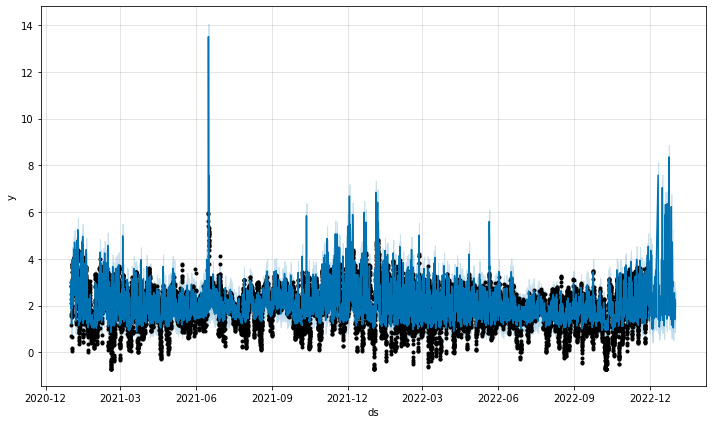

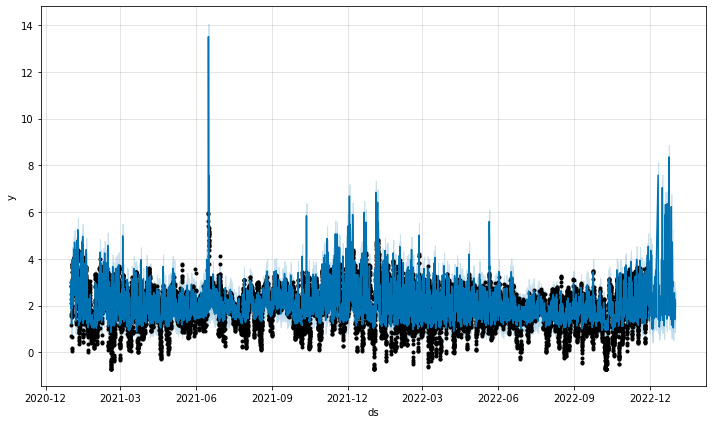

In [16]:
model_new.plot(forecast_data)

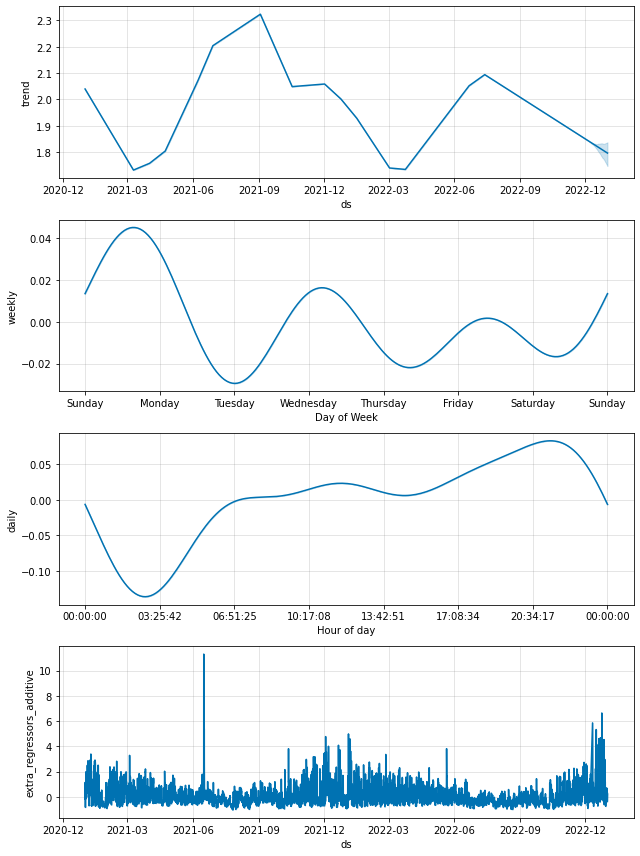

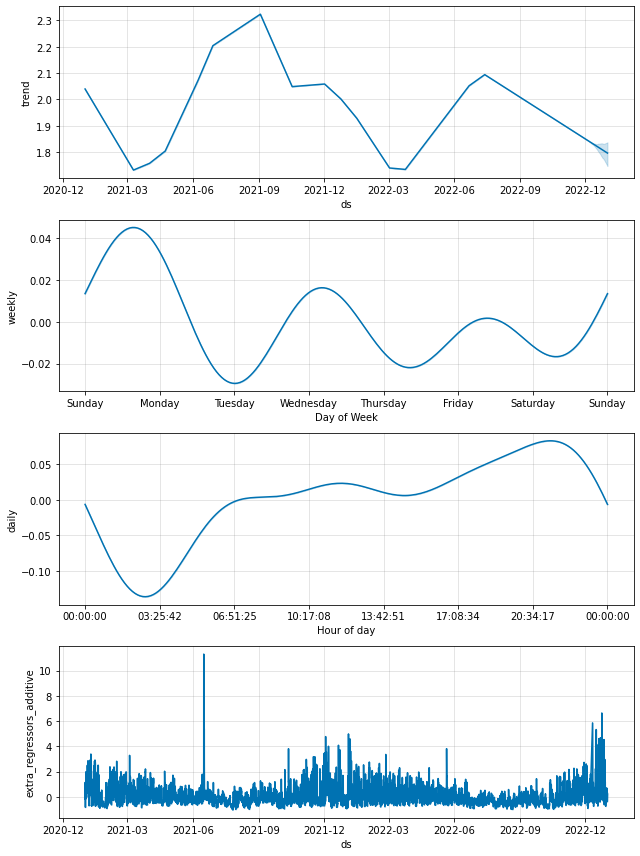

In [17]:
model_new.plot_components(forecast_data)

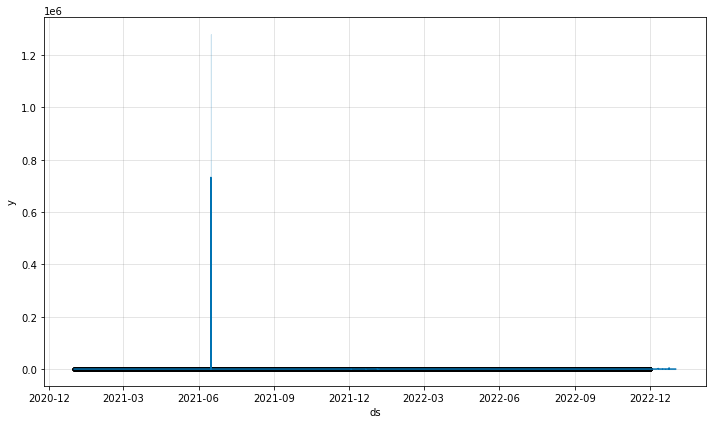

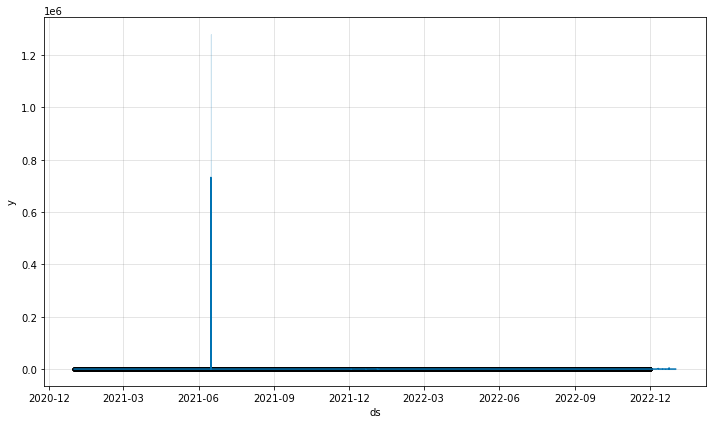

In [18]:
forecast_data_orig = forecast_data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])
model_new.plot(forecast_data_orig)

In [19]:
df_train['y_log'] = df_train['y']
df_train['y'] = df_train['y_orig']

In [20]:
final_df = pd.DataFrame(forecast_data_orig)
import plotly.graph_objs as go
import plotly.offline as py

actual_chart = go.Scatter(y=df_train['y_orig'], name='Actual')
predicted_chart = go.Scatter(y=final_df['yhat'], name='Predicted')
predicted_chart_upper = go.Scatter(y=final_df['yhat_upper'], name='Predicted Upper')
predicted_chart_lower = go.Scatter(y=final_df['yhat_lower'], name='Predicted Lower')
real_actual = go.Scatter(y=df_test['components.pm2_5'] ,name='Real Actual')
py.plot([actual_chart,predicted_chart,predicted_chart_upper,predicted_chart_lower, real_actual])

'temp-plot.html'